In [1]:
from qiskit.visualization import plot_histogram
import numpy as np
import qiskit as qk
import scipy
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.circuit import QuantumCircuit

from qiskit.aqua.operators import *
from qiskit.circuit.library import PhaseEstimation, RYGate

from qiskit.aqua.algorithms.phase_estimators import PhaseEstimator, bit_string_to_phase


### Phase estimation with an eigenvector

The simplest phase estimation scenario consists of estimating the eigenvalue of a unitary/eigenvector pair. In general, the input state may be a superposition of eigenvectors. But, here we considera single component.

Let's write a function that takes a unitary operator $U$ and a state $| \phi \rangle$ (assumed to be an eigenstate) such that $U | \phi \rangle = e^{2 i \pi \phi} | \phi \rangle $ and returns the phase $\phi$. The input unitary must be a circuit. The input state is given as a circuit that generates $|\phi\rangle$ when operating on the state $|0\rangle$, the zero eigenstate of the string of $Z$ operators. The phase is found using the method `single_phase` which computes the phase from the bit string with the largest amplitude.

In [2]:
def one_phase(unitary_circuit, input_state_circuit=None, n_eval_qubits = 8,
             backend = Aer.get_backend('qasm_simulator')):
    """ Run phase estimation with operator, eigenvalue pair `unitary_circuit`,
        `input_state_circuit`. Return the bit string with the largest amplitude.
    """
    qi = QuantumInstance(backend=backend, shots=100000)
    p_est = PhaseEstimator(num_evaluation_qubits=n_eval_qubits,
                           unitary=unitary_circuit,
                           quantum_instance=qi,
                           input_state_circuit=input_state_circuit)
    p_est.run()
    phase = p_est.single_phase()
    return phase

As an example, take the Pauli $Z$ operator which has eigenvalue, -vector pairs $(1, |0\rangle)$ and $(-1, |1\rangle)$.  First, we pass no input state circuit, so that the eigenvector is $|0\rangle$. The phase is determined by $e^{2i\pi \phi} = 1$, so that $\phi = 0$.

In [3]:
unitary_circuit = Z.to_circuit()
input_state_circuit = None
one_phase(unitary_circuit, input_state_circuit)

0.0

We repeat the exercise with eigenvector $|1\rangle$, which is obtained with by passing an input-state circuit consisting of an $X$ gate. That is $X|0\rangle = |1\rangle$. In this case, the phase is determined by $e^{2i\pi \phi} = -1$, so that $\phi = 1/2$.

In [4]:
input_state_circuit = X.to_circuit()
one_phase(unitary_circuit, input_state_circuit)

0.5

Now, we demonstrate the case $X |+\rangle = |+\rangle$, so that $\phi = 0$ as above.

In [5]:
unitary_circuit = X.to_circuit()
input_state_circuit = H.to_circuit()
one_phase(unitary_circuit, input_state_circuit)

0.0

And $X|-\rangle = -|-\rangle  = e^{i\pi} |-\rangle$.

In [6]:
input_state_circuit = X.to_circuit()
input_state_circuit.append(H.to_circuit(), [0])
one_phase(unitary_circuit, input_state_circuit)

0.5

### Multiple phases

Suppose the input state is a coherent superposition of eigenstates. We'd like to recover all of the phases. This is typically a neccessary step in finding the minimum eigenvalue of a Hermitian operator using phase estimation.
Let's write a function to recover all phases. The only difference from the function `one_phase` defined above is that instead calling the `single_phase` method, we return the `PhaseEstimator` instance which stores the weights for all bit strings.

In [7]:
def all_phases(unitary_circuit, input_state_circuit=None, num_evaluation_qubits = 8,
             backend = Aer.get_backend('qasm_simulator')):
    """ Run phase estimation with operator, eigenvalue pair `unitary_circuit`,
        `input_state_circuit`. Return the bit string with the largest amplitude.
    """
    qi = QuantumInstance(backend=backend, shots=100000)
    phase_est = PhaseEstimator(num_evaluation_qubits=num_evaluation_qubits,
                           unitary=unitary_circuit,
                           quantum_instance=qi,
                           input_state_circuit=input_state_circuit)
    phase_est.run()
    return phase_est 

Lets take again as the unitary the Pauli $Z$ operator. For the input state, we take $H|0\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$, this is a superposition with equal weights on the eigenvectors with phases $\phi=0$ and $\phi=1/2$.

In [8]:
unitary_circuit = Z.to_circuit()
input_state_circuit = H.to_circuit()
p_est = all_phases(
    unitary_circuit, input_state_circuit, backend=Aer.get_backend('statevector_simulator'))

We have used the state vector simulator, which returns probabilities for all of computational basis vectors of the phase-recording register. Even the probabilities that are theoretically zero will have small non-zero values due to finite precision calculations. So, we filter the phases, keeping only probabilities greater than a small cutoff. We also convert the bit strings to floating-point decimal phases in $[0, 1)$ using the `as_float` keyword.

In [9]:
p_est.filter_phases(1e-15, as_float=True)

{0.0: 0.4999999999999999, 0.5: 0.4999999999999999}

In this case, it was relatively easy to find that part of the spectrum of $U$ that is represented in the input vector.

### Approximate phases

Estimating phases that cannot be represented exactly by `num_evaluation_qubits` is in general more difficult than the examples above. In the following we investigate why it is difficult.

Here we estimate the phase for the problem $e^{2i\pi \phi Z} |1\rangle = e^{2i\pi \phi}|1\rangle$.

In [10]:
phi = 1 / 3
unitary_circuit = (phi * 2 * np.pi * Z).exp_i().to_circuit()
input_state_circuit = X.to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit)
p_est.single_phase()

0.33203125

The estimation of the phase seems reasonable.
However, counts were recorded for more than one bit string. In fact, counts were recorded for most of the 256 bit strings.

In [11]:
len(p_est.phases)

219

Plotting only those bit strings with the highest frequencies, we see that the maximum frequncy is obtained for the phase closest to $1/3$. (out of all phases in $[0,1)$ representabe by 8 bits)

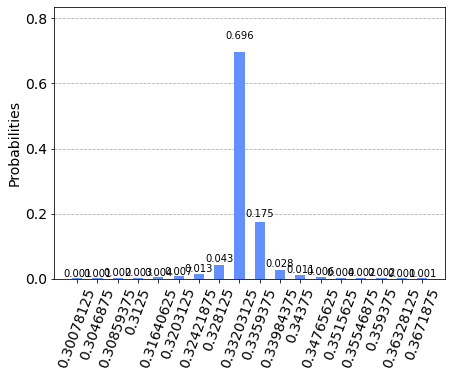

In [12]:
plot_histogram(p_est.filter_phases(100, as_float=True))

Now, we estimate the phase for the problem $e^{2i\pi \phi Z} |0\rangle = e^{-2i\pi \phi}|1\rangle$. This differs from the previous problem only in that we no longer prepare the input state, with the result that it is equal to $|0\rangle$.

In [13]:
input_state_circuit = None
p_est = all_phases(unitary_circuit, input_state_circuit)
p_est.single_phase()

0.66796875

The estimated phase is not $\approx -1/3$ but rather $\approx 1 - 1/3$ because the phase wraps so that it remains in the unit interval. If were using this method to estimate the eigenvalues of $H$ via $U = e^{-2i\pi \phi H}$ with $H=Z$, simply looking for the smallest phase would not give the correct result. Similarly, if $\phi \lambda_j$, where $\lambda_j$ is the $j$th eigenvalue of the Hermitian operator $H$, is too large in magnitude, the phase will wrap.

But, there is another problem, as well. It can be illustrated in the following example. Let the input state be a superposition of states with both the $1/3$ and the $-1/3$ phases.

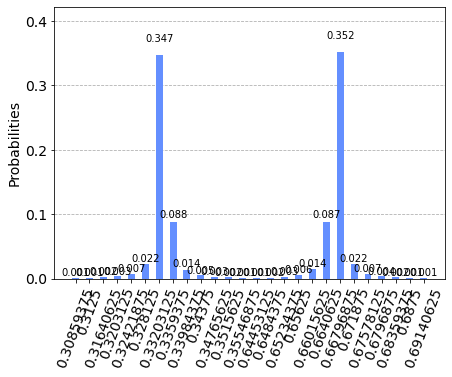

In [14]:
input_state_circuit = H.to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit)
plot_histogram(p_est.filter_phases(100, as_float=True))

Counts are measured for all of the bit strings. In this case, since the unitary is of dimension two, keeping the two phases with the largest weights would work.
But, consider what happens if we take not an equal superposition, but one with coefficients of $\cos(2\pi/3) = 1/2$ and $\sin(2\pi/3)\approx 0.866$. 

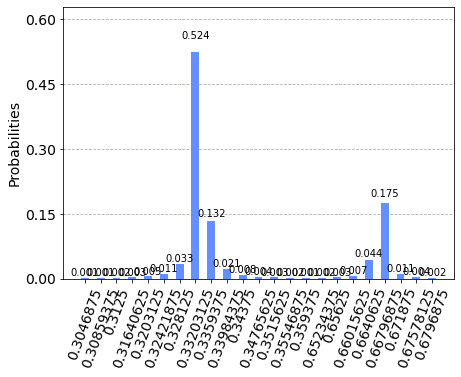

In [15]:
alpha = 1 / 3
input_state_circuit = (alpha * 2 * np.pi * Y).exp_i().to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit)
plot_histogram(p_est.filter_phases(100, as_float=True))

In this case, we can still get both phases by taking the two largest frequencies.
But, for a more unequal superposition, with `alpha = 1 / 20` (corresponding to coefficients of $\approx 0.95$ and $0.3$), we see that the two largest frequencies no longer correspond to the spectrum of $U$.

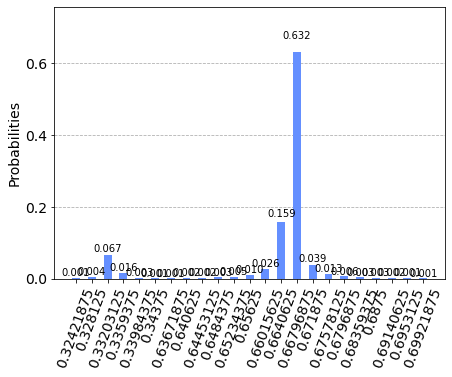

In [16]:
alpha = 1 / 20
input_state_circuit = (alpha * 2 * np.pi * Y).exp_i().to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit)
plot_histogram(p_est.filter_phases(100, as_float=True))

We see empirically that changing the number of evaluation qubits will not *easily* allow use to recover the phases again. For example, we repeat the last example with `num_evaluation_qubits` equal to $10$ and to $4$.

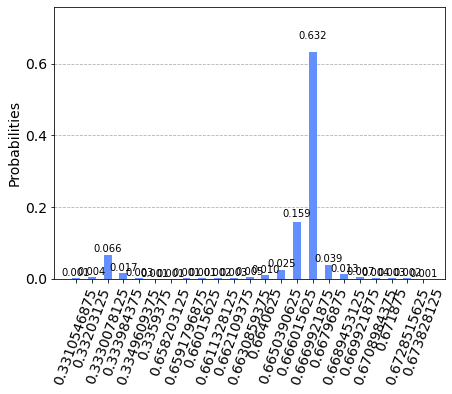

In [17]:
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=10)

plot_histogram(p_est.filter_phases(100, as_float=True))

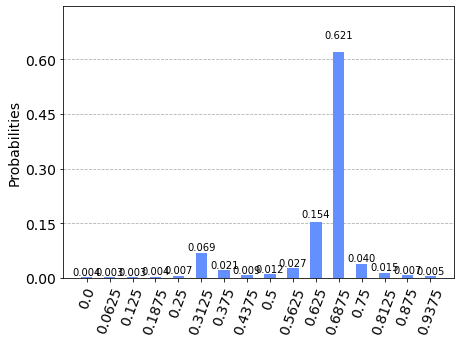

In [18]:
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=4)
plot_histogram(p_est.filter_phases(100, as_float=True))

(Note: I expect that, although it may be prohibitively expensive, increasing the number of qubits enough will indeed resolve the spectrum. This seems to be the case, as shown further below.)

However, by adjusting $\phi$ so that $\phi \lambda_j$ is more nearly representable by `num_evaluation_qubits` bits, once again the two most frequent phases correspond to the spectrum. For example, for $\lambda_j = \pm 1$ and `phi = 1/5`, we see

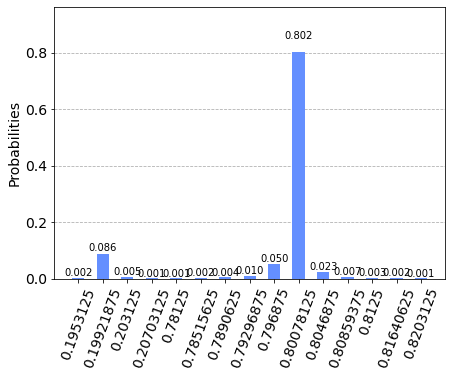

In [19]:
phi = 1 / 5
unitary_circuit = (phi * 2 * np.pi * Z).exp_i().to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=8)
plot_histogram(p_est.filter_phases(100, as_float=True))

In fact, for some values of `phi`, we can represent the phases exactly and so suppress the artifacts completely.

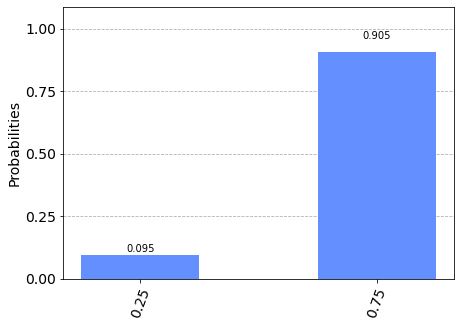

In [20]:
phi = 1 / 4
unitary_circuit = (phi * 2 * np.pi * Z).exp_i().to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=6)
plot_histogram(p_est.filter_phases(100, as_float=True))

If $\phi$ is close to a phase that is easily representable, then we see that the resolution of the spectrum *is* sensitive to the number of qubits (more is not neccessarily better). Consider `phi = 1/4 + 0.005` and `num_evaluation_qubits` equal to `6` and `10`. We see that the spectrum is resolved for `10`, but not for `6`.

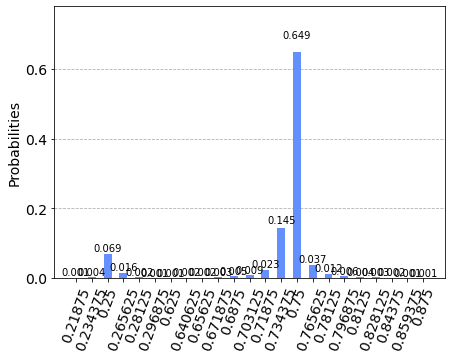

In [21]:
phi = 1 / 4 + 0.005
unitary_circuit = (phi * 2 * np.pi * Z).exp_i().to_circuit()
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=6)
plot_histogram(p_est.filter_phases(100, as_float=True))

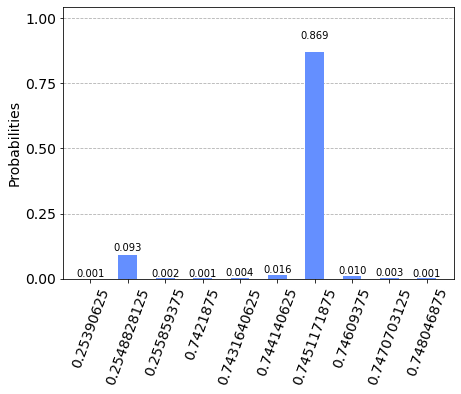

In [22]:
p_est = all_phases(unitary_circuit, input_state_circuit, num_evaluation_qubits=10)
plot_histogram(p_est.filter_phases(100, as_float=True))

Increasing the number of qubits to `11` is slightly *worse* for resolving the spectrum.